# Monte Carlo simulator
By: Magnus Kvåle Helliesen

# *Under construction*

In [43]:
import pandas as pd
import numpy as np
from numpy.linalg import eig, inv
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

Suppose we have a matrix of data $X=\{x_t\}_{t=0}^{T-1}$, where $x_t=(x_{1,t}, x_{2,t}, \ldots, x_{N,t})$ is a vector of variabels at time $t$.

In [44]:
class MonteCarlo():
    def __init__(self, df: pd.DataFrame):
        self._df = df

    @property
    def df(self):
        return self._df

    def _find_eig(self):
        array = self.df.to_numpy()

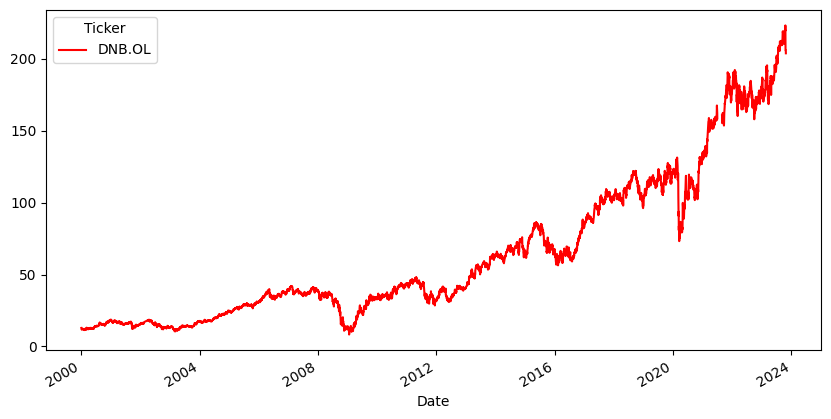

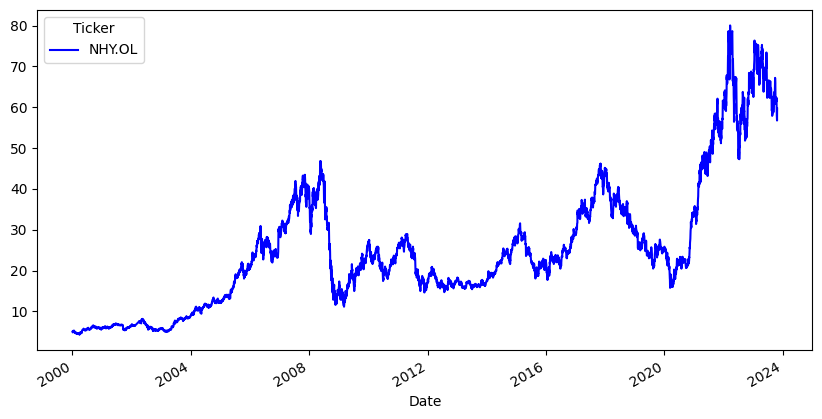

In [87]:
# Fetching data
data = {}
for ticker in ['NHY.OL', 'DNB.OL']:
    data[ticker] = yf.Ticker(ticker).history(period='max')

# Transforming data
df = (
    pd.concat(data)[['Close']]
    .reset_index()
    .rename(columns={'level_0': 'Ticker'})
    .pivot(index='Date', columns='Ticker', values='Close')
)

df[['DNB.OL']].plot(color='b', figsize=(10, 5))
df[['NHY.OL']].plot(color='b', figsize=(10, 5))

<Axes: xlabel='Date'>

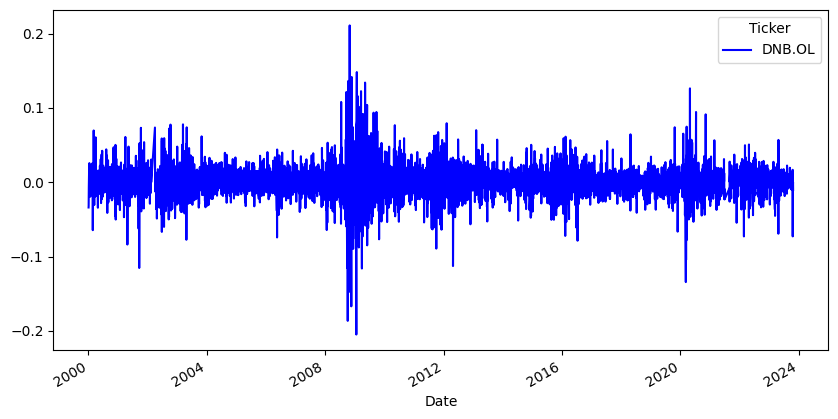

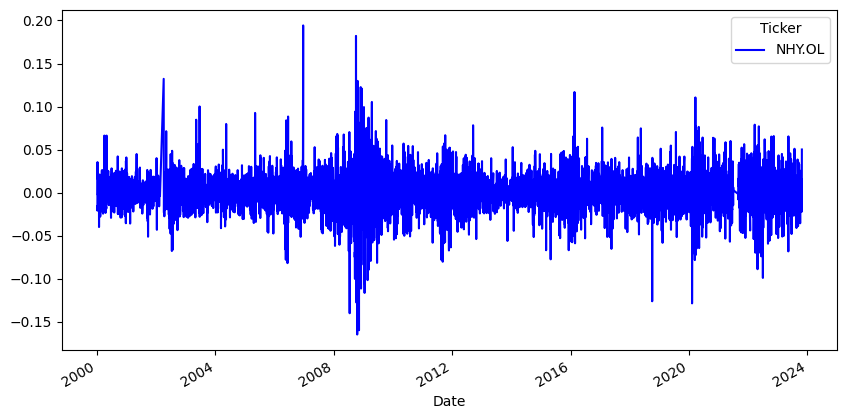

In [88]:
# Calculating log-differences and removing missing values
df_diff = np.log(df).diff().dropna()

df_diff[['DNB.OL']].plot(color='b', figsize=(10, 5))
df_diff[['NHY.OL']].plot(color='b', figsize=(10, 5))

In [89]:
models = {}
models['DNB.OL'] = arch_model(df_diff['DNB.OL'], vol='garch', p=1, o=0, q=1, rescale=False)
models['NHY.OL'] = arch_model(df_diff['NHY.OL'], vol='garch', p=1, o=0, q=1, rescale=False)

In [91]:
fits = {key: val.fit() for key, val in models.items()}

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7433867832.851684
Iteration:      2,   Func. Count:     19,   Neg. LLF: 59849642.99747024
Optimization terminated successfully    (Exit mode 0)
            Current function value: -15501.62060936447
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3.147386387519305e+20
Iteration:      2,   Func. Count:     18,   Neg. LLF: -14564.025691709136
Optimization terminated successfully    (Exit mode 0)
            Current function value: -14564.025722963916
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


<Axes: xlabel='Date'>

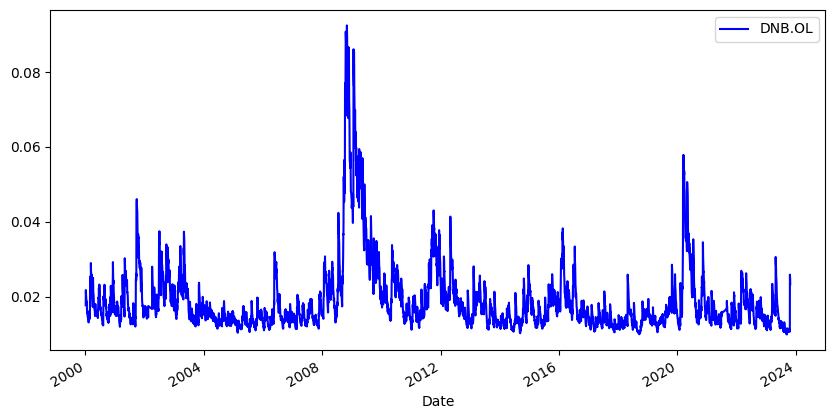

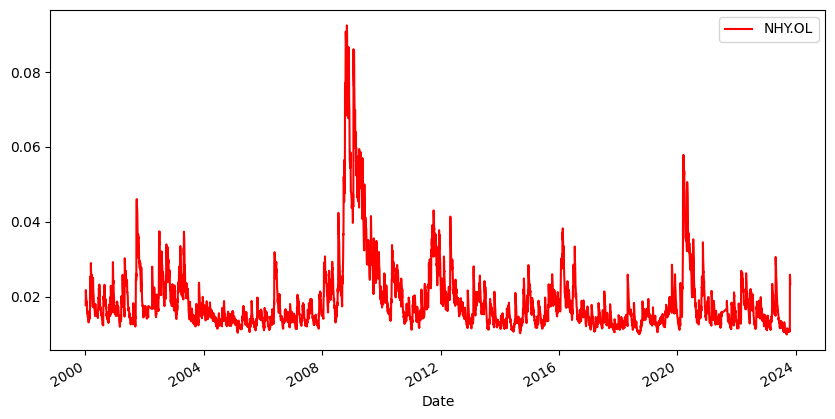

In [98]:
pd.DataFrame({'DNB.OL': fits['DNB.OL'].conditional_volatility}).plot(color='b', figsize=(10, 5))
pd.DataFrame({'NHY.OL': fits['DNB.OL'].conditional_volatility}).plot(color='r', figsize=(10, 5))